In [1]:
import lightly
import lightly.utils.io as io
import torchvision
from PIL import Image
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
import sklearn
import torch.optim as optim

import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import json


In [2]:
root_results_path = '/projects/self_supervised/results/bitewings_caries_moco'

In [3]:
#load config
conf_path = os.path.join(root_results_path,'conf.json')
with open(conf_path,'r') as f:
    conf = json.load(f)

#load embeddings
embeddings_path = os.path.join(root_results_path,'embeddings.csv')
train_embeddings, train_labels, train_filenames = io.load_embeddings(embeddings_path)

#load model
model_path = os.path.join(root_results_path,'checkpoint.pth')

num_ftrs = conf['num_ftrs']

resnet = lightly.models.ResNetGenerator('resnet-18')
last_conv_channels = list(resnet.children())[-1].in_features
backbone = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.Conv2d(last_conv_channels, num_ftrs, 1),
    nn.AdaptiveAvgPool2d(1)
)

if conf['model_name'] == 'simclr':
    model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)
elif conf['model_name'] == 'moco':
    model = lightly.models.MoCo(backbone, num_ftrs=num_ftrs, m=0.99, batch_shuffle=True)

encoder = lightly.embedding.SelfSupervisedEmbedding(
    model,
    None,
    None,
    None
)

encoder.model.load_state_dict(torch.load(model_path))
encoder.model.eval()

MoCo(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Batch

In [5]:
# import os
# from shutil import copyfile

# #get images with caries and no caries
# imgs_path = '/projects/self_supervised/data/bitewings_caries/images'
# masks_path = '/projects/self_supervised/data/bitewings_caries/masks'

# healthy_path = '/projects/self_supervised/data/bitewings_caries/classification_dataset/healthy'
# caries_path = '/projects/self_supervised/data/bitewings_caries/classification_dataset/caries'


# healthy = []
# caries = []

# for filename in os.listdir(imgs_path):
#     if filename in os.listdir(masks_path):
#         mask = Image.open(os.path.join(masks_path,filename))
#         #print(np.array(mask).max())
#         if np.array(mask).max() == 0:
#             healthy.append(filename)
#             src_file_path = os.path.join(imgs_path,filename)
#             dest_file_path = os.path.join(healthy_path,filename)
            
#         else:
#             caries.append(filename)
#             src_file_path = os.path.join(imgs_path,filename)
#             dest_file_path = os.path.join(caries_path,filename)
            
#         copyfile(src_file_path,dest_file_path)
            
            
# print('healthy:',len(healthy))
# print('caries:',len(caries))

healthy: 1153
caries: 2689


healthy


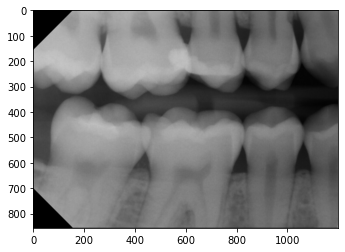

In [6]:
#load an image
data_path = '/projects/self_supervised/data/bitewings_caries/classification_dataset/'
category = 'healthy' # caries, healthy

filename_list = os.listdir(os.path.join(data_path,category))
idx = np.random.randint(len(filename_list))
filename = filename_list[idx]
    
print(category)
img = Image.open(os.path.join(data_path,category,filename)).convert('RGB')
plt.imshow(img) 

healthy


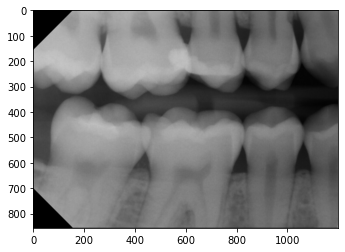

healthy


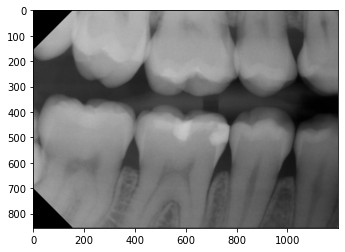

caries


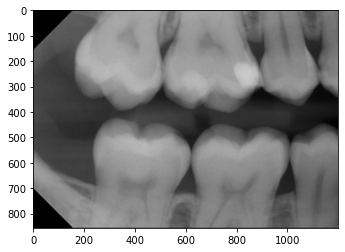

caries


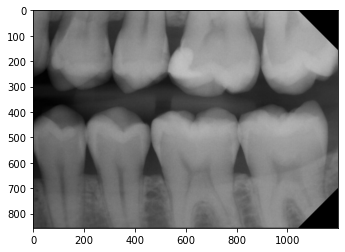

caries


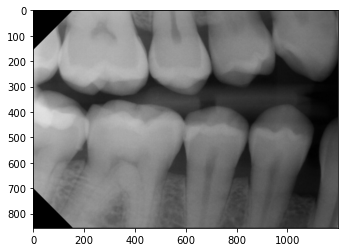

healthy


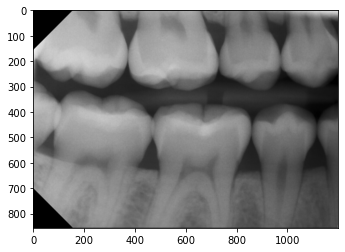

caries


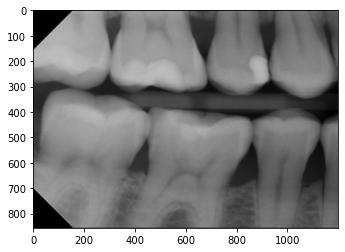

healthy


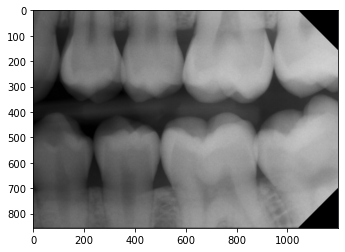

caries


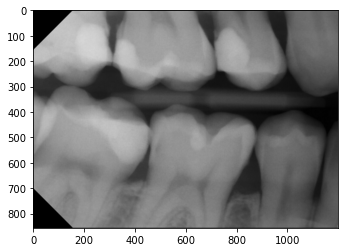

caries


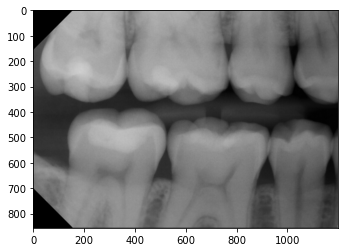

caries


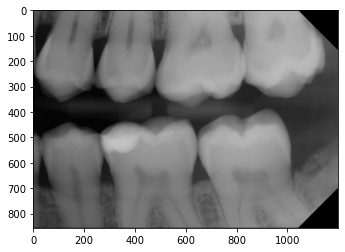

caries


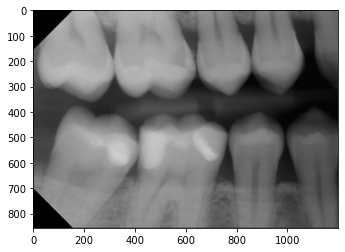

caries


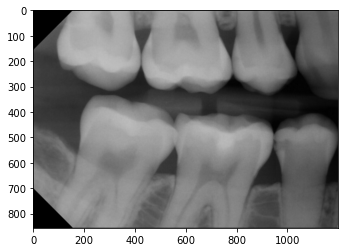

healthy


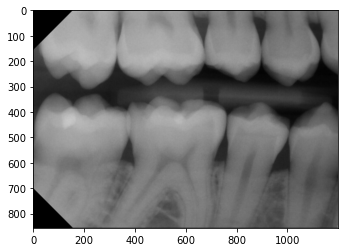

healthy


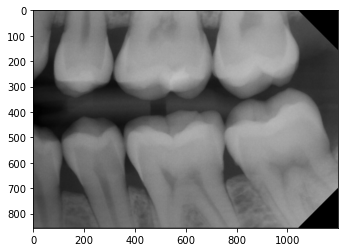

healthy


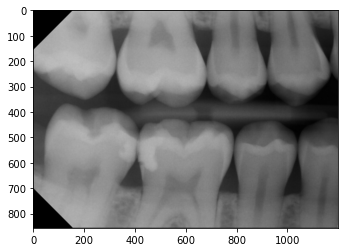

caries


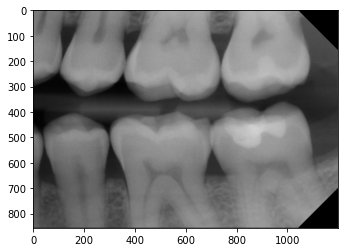

caries


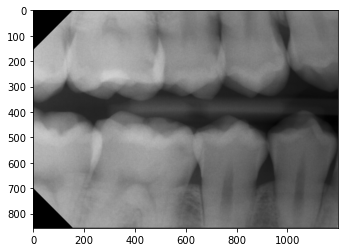

caries


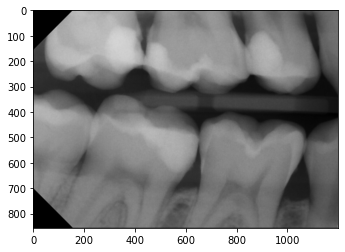

In [8]:
n_neighbors = 20


input_size = conf['input_size']

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

img_tensor = test_transforms(img)
with torch.no_grad():
    #apply the encoder
    img_embed = model.backbone(torch.unsqueeze(img_tensor,0))
    
img_embed = torch.squeeze(torch.squeeze(img_embed,2),2).numpy()
embeddings = np.concatenate((train_embeddings,img_embed))
embeddings = normalize(embeddings)
filenames = train_filenames.copy()
filenames.append(filename)

idx = filenames.index(filename)

#fit nearest neighbours
nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)

for neighbor_idx in indices[idx][1:]:
    filename = filenames[neighbor_idx]
    if filename in os.listdir(os.path.join(data_path,'caries')):
        img = Image.open(os.path.join(data_path,'caries',filename)).convert('RGB')
        print('caries')
    elif filename in os.listdir(os.path.join(data_path,'healthy')):
        img = Image.open(os.path.join(data_path,'healthy',filename)).convert('RGB')
        print('healthy')
    
    plt.imshow(img)
    plt.show()

# Linear probe

In [9]:
max_epochs = 10
input_size = 64
batch_size = 16
num_workers = 4
output_dim = 2

In [10]:
train_classifier_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

dataset_classifier = lightly.data.LightlyDataset(
    input_dir=data_path,
    transform=train_classifier_transforms
)


X_train, X_test = train_test_split(np.arange(len(dataset_classifier)), test_size=0.33, random_state=42)

dataset_train_classifier = torch.utils.data.Subset(dataset_classifier, X_train)
dataloader_train_classifier = torch.utils.data.DataLoader(
    dataset_classifier,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

dataset_test_classifier = torch.utils.data.Subset(dataset_classifier, X_test)
dataloader_test_classifier = torch.utils.data.DataLoader(
    dataset_test_classifier,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers
)

In [37]:
#pytorch module
class Classifier_torch(nn.Module):
    def __init__(self, model,num_ftrs,output_dim):
        super().__init__()
        
        self.net = model
        
        # freeze the layers
        for p in self.net.parameters():  # reset requires_grad
            p.requires_grad = False

        self.fc = nn.Linear(num_ftrs, output_dim)

    def forward(self, x):
        with torch.no_grad():
            y_hat = self.net.backbone(x).squeeze()
            y_hat = nn.functional.normalize(y_hat, dim=1)
        y_hat = self.fc(y_hat)
        return y_hat

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier_torch = Classifier_torch(encoder.model,num_ftrs,output_dim).to(device)

loss_function = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(classifier_torch.parameters(), lr=0.001)

for epoch in range(max_epochs):

    #train
    train_loss = 0
    for inputs,labels,_ in dataloader_train_classifier:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = loss_function(classifier_torch(inputs), labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    #evaluate
    val_loss = 0
    ground_truth_list = []
    predictions_list = []
    for inputs,labels,_ in dataloader_test_classifier:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = classifier_torch(inputs)
        probabilities, predicted = torch.max(outputs.data, 1)
        val_loss += loss_function(outputs, labels.long()).item()
        ground_truth_list += list(labels.cpu())
        predictions_list += list(predicted.cpu())
        
    acc = sklearn.metrics.accuracy_score(ground_truth_list,predictions_list)
    f1 = sklearn.metrics.f1_score(ground_truth_list,predictions_list)
    precision = sklearn.metrics.precision_score(ground_truth_list,predictions_list)
    recall = sklearn.metrics.recall_score(ground_truth_list,predictions_list)
            
    print(f'[{epoch}] train loss: {train_loss:.3f} validation loss: {val_loss:.3f} acc: {acc:.3f} f1: {f1:.3f} precision: {precision:.3f} recall: {recall:.3f}')

    
    

[0] train loss: 2305.074 validation loss: 741.067 acc: 0.716 f1: 0.000 precision: 0.000 recall: 0.000


/home/jose/miniconda3/envs/sort_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1] train loss: 2304.791 validation loss: 741.239 acc: 0.718 f1: 0.011 precision: 1.000 recall: 0.006
[2] train loss: 2301.975 validation loss: 743.598 acc: 0.718 f1: 0.033 precision: 0.600 recall: 0.017
[3] train loss: 2314.608 validation loss: 741.482 acc: 0.714 f1: 0.000 precision: 0.000 recall: 0.000
[4] train loss: 2298.775 validation loss: 745.002 acc: 0.717 f1: 0.027 precision: 0.556 recall: 0.014
[5] train loss: 2304.185 validation loss: 739.934 acc: 0.716 f1: 0.000 precision: 0.000 recall: 0.000


/home/jose/miniconda3/envs/sort_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[6] train loss: 2295.774 validation loss: 741.636 acc: 0.715 f1: 0.000 precision: 0.000 recall: 0.000
[7] train loss: 2306.495 validation loss: 740.545 acc: 0.716 f1: 0.000 precision: 0.000 recall: 0.000


/home/jose/miniconda3/envs/sort_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[8] train loss: 2302.017 validation loss: 742.600 acc: 0.714 f1: 0.000 precision: 0.000 recall: 0.000
[9] train loss: 2301.131 validation loss: 742.741 acc: 0.715 f1: 0.011 precision: 0.400 recall: 0.006
